In [2]:
!pip install ultralytics

In [3]:
import os
DATASET_PATH = "/kaggle/input/m2cai-tool/m2cai16-tool-locations"

if(1):
  ANNOTATIONS_DIR = "/kaggle/input/m2cai-tool/m2cai16-tool-locations/Annotations"
  IMAGES_DIR = "/kaggle/input/m2cai-tool/m2cai16-tool-locations/JPEGImages"
  YOLO_DIR = "/kaggle/working/m2cai-yolo"
  CLASS_LIST_FILE = "/kaggle/input/class-list-1/class_list.txt"

# Create folders
os.makedirs(f"{YOLO_DIR}/images/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/images/val", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/images/test", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/val", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/test", exist_ok=True)

In [4]:
print("✅ Example check:", os.path.exists("/kaggle/input/m2cai-tool/m2cai16-tool-locations/JPEGImages/v03_114050.jpg"))

✅ Example check: True


In [5]:
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil

# === Load class list ===
with open(CLASS_LIST_FILE, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
class_to_id = {name: idx for idx, name in enumerate(class_names)}
print("✅ Loaded classes:", class_to_id)

# === Setup output folders ===
for split in ["train", "val", "test"]:
    os.makedirs(f"{YOLO_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{YOLO_DIR}/labels/{split}", exist_ok=True)

# === Load all XML files ===
xml_files = [f for f in os.listdir(ANNOTATIONS_DIR) if f.endswith(".xml")]
print(f"📁 Found {len(xml_files)} annotation files.")

# === Split the dataset ===
train_files, temp_files = train_test_split(xml_files, test_size=0.30, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# === VOC to YOLO Converter ===
def convert_annotation(xml_path, output_path, img_filename):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        img_w = int(root.find("size/width").text)
        img_h = int(root.find("size/height").text)

        label_lines = []
        for obj in root.findall("object"):
            cls = obj.find("name").text.strip().lower()
            if cls not in class_to_id:
                print(f"⚠️ Unknown class '{cls}' in {img_filename}, skipping.")
                continue

            cls_id = class_to_id[cls]

            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)

            # YOLO format
            x_center = ((xmin + xmax) / 2) / img_w
            y_center = ((ymin + ymax) / 2) / img_h
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h

            label_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        if label_lines:
            with open(output_path, "w") as f:
                f.write("\n".join(label_lines))
        else:
            print(f"⚠️ No objects found in {img_filename}. Skipping label file.")
    except Exception as e:
        print(f"❌ Error in {img_filename}: {e}")

# === Copy and Convert ===
def process_set(file_list, set_type):
    print(f"🔄 Processing {set_type} set with {len(file_list)} samples...")
    for xml_file in file_list:
        #file_id = xml_file.replace(".xml", "")
        file_id = os.path.splitext(os.path.basename(xml_file))[0]
        img_file = f"{file_id}.jpg"
        src_img = os.path.join(IMAGES_DIR, img_file)
        #print(f"🧪 DEBUG img_file = {img_file}")
        dst_img = os.path.join(YOLO_DIR, f"images/{set_type}", img_file)
        label_path = os.path.join(YOLO_DIR, f"labels/{set_type}", f"{file_id}.txt")

        if not os.path.exists(src_img):
            print(f"⚠️ Missing image: {src_img}")
            continue

        shutil.copy2(src_img, dst_img)
        convert_annotation(os.path.join(ANNOTATIONS_DIR, xml_file), label_path, file_id)

# === Run ===
process_set(train_files, "train")
process_set(val_files, "val")
process_set(test_files, "test")

print("✅ Conversion complete!")


✅ Loaded classes: {'grasper': 0, 'bipolar': 1, 'hook': 2, 'scissors': 3, 'clipper': 4, 'irrigator': 5, 'specimenbag': 6}
📁 Found 2811 annotation files.
🔄 Processing train set with 1967 samples...
🔄 Processing val set with 422 samples...
🔄 Processing test set with 422 samples...
✅ Conversion complete!


In [6]:
import yaml

data_yaml = {
    'train': '/kaggle/working/m2cai-yolo/images/train',
    'val': '/kaggle/working/m2cai-yolo/images/val',
    'test': '/kaggle/working/m2cai-yolo/images/test',
    'nc': 7,
    'names': ['Grasper', 'Bipolar', 'Hook', 'Scissors', 'Clipper', 'Irrigator', 'SpecimenBag']
}

with open('/kaggle/working/m2cai-yolo/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("✅ data.yaml file created in /kaggle/working/m2cai-yolo/")


✅ data.yaml file created in /kaggle/working/m2cai-yolo/


In [7]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Or yolov8s.pt, yolov8m.pt, etc.
model.train(data="/kaggle/working/m2cai-yolo/data.yaml", epochs=50, imgsz=640, batch=16, name="m2cai_yolo")


100%|██████████| 6.25M/6.25M [00:00<00:00, 181MB/s]

Ultralytics 8.3.117 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/m2cai-yolo/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=m2cai_yolo, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 48.2MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 172MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 858.7±360.4 MB/s, size: 29.7 KB)


train: Scanning /kaggle/working/m2cai-yolo/labels/train... 1967 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1967/1967 [00:01<00:00, 1028.79it/s]

train: New cache created: /kaggle/working/m2cai-yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 586.6±256.3 MB/s, size: 24.1 KB)


val: Scanning /kaggle/working/m2cai-yolo/labels/val... 422 images, 0 backgrounds, 0 corrupt: 100%|██████████| 422/422 [00:00<00:00, 634.95it/s] 

val: New cache created: /kaggle/working/m2cai-yolo/labels/val.cache


Plotting labels to runs/detect/m2cai_yolo/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/m2cai_yolo
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.17G      1.854      3.562      1.807         43        640: 100%|██████████| 123/123 [00:26<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.07it/s]

                   all        422        581      0.356      0.346      0.304      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.18G      1.691      2.514      1.608         46        640: 100%|██████████| 123/123 [00:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.36it/s]

                   all        422        581       0.51      0.574      0.549      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.18G      1.659      2.142       1.58         57        640: 100%|██████████| 123/123 [00:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.93it/s]


                   all        422        581      0.671      0.606      0.685       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.18G      1.637      1.901      1.566         49        640: 100%|██████████| 123/123 [00:22<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.08it/s]


                   all        422        581      0.747       0.65      0.804      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.18G      1.587      1.666      1.521         36        640: 100%|██████████| 123/123 [00:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.92it/s]

                   all        422        581      0.676      0.754      0.788      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.18G      1.565      1.497      1.511         48        640: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.29it/s]

                   all        422        581      0.737      0.732      0.805      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.18G       1.55      1.409      1.493         42        640: 100%|██████████| 123/123 [00:22<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.23it/s]


                   all        422        581      0.837       0.82      0.889      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.18G      1.535      1.355      1.472         57        640: 100%|██████████| 123/123 [00:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.89it/s]


                   all        422        581      0.854      0.802      0.878      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.18G      1.492      1.247      1.443         49        640: 100%|██████████| 123/123 [00:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.19it/s]


                   all        422        581      0.782      0.752      0.823      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.18G      1.466       1.22      1.426         37        640: 100%|██████████| 123/123 [00:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.14it/s]

                   all        422        581      0.871       0.85      0.907      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.18G      1.451      1.189      1.412         54        640: 100%|██████████| 123/123 [00:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.10it/s]


                   all        422        581      0.865      0.834      0.912       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.18G      1.417      1.131      1.397         54        640: 100%|██████████| 123/123 [00:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.92it/s]


                   all        422        581      0.826      0.864      0.912      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.18G      1.417      1.117      1.397         42        640: 100%|██████████| 123/123 [00:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.07it/s]


                   all        422        581      0.842      0.809      0.898      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.18G      1.411      1.085      1.398         36        640: 100%|██████████| 123/123 [00:22<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.07it/s]

                   all        422        581      0.904      0.849      0.929      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.18G      1.369      1.038       1.37         52        640: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.39it/s]

                   all        422        581      0.899      0.911      0.948      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.18G      1.362      1.009      1.371         43        640: 100%|██████████| 123/123 [00:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.21it/s]

                   all        422        581      0.903      0.903      0.939      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.18G      1.348     0.9838      1.356         48        640: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.06it/s]


                   all        422        581      0.931      0.885       0.94       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.18G      1.351     0.9735      1.345         41        640: 100%|██████████| 123/123 [00:22<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.13it/s]

                   all        422        581       0.91      0.919      0.946      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.18G      1.336     0.9592      1.339         46        640: 100%|██████████| 123/123 [00:22<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.67it/s]

                   all        422        581      0.877      0.872      0.917      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.18G      1.315     0.9234      1.325         36        640: 100%|██████████| 123/123 [00:22<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.06it/s]

                   all        422        581      0.897      0.876      0.931      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.18G      1.321     0.9247      1.325         36        640: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.30it/s]


                   all        422        581       0.92       0.91       0.95      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.18G      1.284     0.8715      1.307         47        640: 100%|██████████| 123/123 [00:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.06it/s]

                   all        422        581      0.923      0.873      0.938      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.18G      1.287     0.8853      1.303         35        640: 100%|██████████| 123/123 [00:22<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.09it/s]

                   all        422        581      0.948      0.903      0.955        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.18G      1.266     0.8507      1.292         36        640: 100%|██████████| 123/123 [00:22<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.97it/s]

                   all        422        581      0.939      0.892      0.952      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.18G       1.26     0.8425      1.288         41        640: 100%|██████████| 123/123 [00:22<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.08it/s]


                   all        422        581      0.931      0.904      0.952      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.18G       1.24     0.8095      1.265         42        640: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.32it/s]


                   all        422        581      0.938      0.914      0.961      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.18G      1.218     0.8014      1.269         36        640: 100%|██████████| 123/123 [00:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.34it/s]

                   all        422        581      0.937      0.913      0.956       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.18G      1.212     0.7974      1.257         48        640: 100%|██████████| 123/123 [00:22<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.34it/s]

                   all        422        581      0.925      0.927      0.957        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.18G      1.202     0.7893      1.249         51        640: 100%|██████████| 123/123 [00:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.52it/s]

                   all        422        581       0.96      0.934      0.962      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.18G      1.173     0.7702      1.228         36        640: 100%|██████████| 123/123 [00:22<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.37it/s]

                   all        422        581      0.926      0.938      0.958      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.18G      1.174     0.7531      1.237         47        640: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.26it/s]

                   all        422        581      0.941      0.928      0.956      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.18G      1.151     0.7486      1.234         39        640: 100%|██████████| 123/123 [00:22<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.93it/s]

                   all        422        581      0.944      0.929      0.962      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.18G      1.161     0.7273      1.227         58        640: 100%|██████████| 123/123 [00:22<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.29it/s]

                   all        422        581      0.955      0.934      0.963      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.18G      1.118     0.6986      1.198         35        640: 100%|██████████| 123/123 [00:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.24it/s]


                   all        422        581       0.94      0.938      0.966      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.18G      1.134     0.7063      1.208         42        640: 100%|██████████| 123/123 [00:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.16it/s]

                   all        422        581      0.955       0.92      0.959      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.18G      1.113     0.6906      1.192         63        640: 100%|██████████| 123/123 [00:22<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.76it/s]


                   all        422        581      0.954      0.919      0.967      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.18G      1.113     0.6975      1.201         47        640: 100%|██████████| 123/123 [00:22<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.22it/s]

                   all        422        581      0.952       0.93       0.97      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.18G      1.098     0.6718      1.187         38        640: 100%|██████████| 123/123 [00:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.35it/s]


                   all        422        581       0.95      0.939      0.963      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.18G      1.072     0.6595      1.169         42        640: 100%|██████████| 123/123 [00:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.27it/s]


                   all        422        581      0.948      0.941      0.966      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.18G      1.086      0.672      1.187         40        640: 100%|██████████| 123/123 [00:22<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.31it/s]


                   all        422        581      0.962      0.927       0.97      0.629
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.18G      1.002     0.5125      1.145         21        640: 100%|██████████| 123/123 [00:23<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.06it/s]

                   all        422        581      0.954      0.915      0.958      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.18G     0.9734     0.4869      1.134         21        640: 100%|██████████| 123/123 [00:22<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.19it/s]

                   all        422        581      0.958      0.933      0.969      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.18G     0.9561     0.4702      1.115         21        640: 100%|██████████| 123/123 [00:22<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.26it/s]


                   all        422        581      0.957       0.94      0.967      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.18G     0.9384     0.4618      1.114         19        640: 100%|██████████| 123/123 [00:22<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.41it/s]

                   all        422        581      0.968      0.933      0.969      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.18G     0.9267     0.4554      1.097         23        640: 100%|██████████| 123/123 [00:22<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.63it/s]

                   all        422        581      0.957      0.946      0.968       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.18G     0.8925     0.4427      1.083         20        640: 100%|██████████| 123/123 [00:22<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.62it/s]

                   all        422        581      0.945      0.943      0.962      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.18G     0.8942     0.4415      1.083         16        640: 100%|██████████| 123/123 [00:22<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.39it/s]

                   all        422        581       0.96      0.951      0.969      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.18G     0.8764     0.4294      1.073         24        640: 100%|██████████| 123/123 [00:22<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.29it/s]

                   all        422        581       0.97      0.944      0.968      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.18G     0.8701     0.4279      1.071         18        640: 100%|██████████| 123/123 [00:22<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.15it/s]

                   all        422        581      0.963      0.936      0.968      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.18G     0.8526     0.4235      1.055         21        640: 100%|██████████| 123/123 [00:22<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.44it/s]

                   all        422        581      0.955       0.95      0.971      0.637



50 epochs completed in 0.347 hours.
Optimizer stripped from runs/detect/m2cai_yolo/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/m2cai_yolo/weights/best.pt, 6.2MB

Validating runs/detect/m2cai_yolo/weights/best.pt...
Ultralytics 8.3.117 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.35it/s]


                   all        422        581      0.965      0.939       0.97       0.64
               Grasper        164        204      0.916      0.857       0.94       0.58
               Bipolar         65         65      0.969      0.949      0.956      0.604
                  Hook         44         44      0.994          1      0.995      0.801
              Scissors         60         60          1      0.991      0.995      0.628
               Clipper         66         66      0.982      0.939      0.981       0.68
             Irrigator         64         64      0.935      0.899      0.964      0.491
           SpecimenBag         78         78       0.96      0.936      0.962      0.695


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/m2cai_yolo


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9386dc2680>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [8]:
metrics = model.val(split='test')  # Use test split
print(metrics)

Ultralytics 8.3.117 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 742.1±254.3 MB/s, size: 28.9 KB)


val: Scanning /kaggle/working/m2cai-yolo/labels/test... 422 images, 0 backgrounds, 0 corrupt: 100%|██████████| 422/422 [00:00<00:00, 1239.04it/s]

val: New cache created: /kaggle/working/m2cai-yolo/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:02<00:00,  9.53it/s]


                   all        422        613      0.954      0.937      0.969      0.627
               Grasper        197        240      0.907      0.883      0.925      0.562
               Bipolar         71         71          1      0.957      0.989      0.618
                  Hook         51         51      0.942      0.949      0.977      0.724
              Scissors         52         52      0.929      0.942      0.959      0.602
               Clipper         57         57      0.963      0.905      0.975      0.673
             Irrigator         68         68       0.97      0.963      0.988      0.568
           SpecimenBag         74         74      0.965      0.959      0.972      0.642


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 1.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/m2cai_yolo2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b938652e590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0380

In [9]:
results = model.predict(source="/kaggle/working/m2cai-yolo/images/test", save=True, conf=0.25)


image 1/422 /kaggle/working/m2cai-yolo/images/test/v01_004225.jpg: 384x640 1 Grasper, 34.3ms
image 2/422 /kaggle/working/m2cai-yolo/images/test/v01_007125.jpg: 384x640 2 Graspers, 10.4ms
image 3/422 /kaggle/working/m2cai-yolo/images/test/v01_020150.jpg: 384x640 2 Graspers, 6.3ms
image 4/422 /kaggle/working/m2cai-yolo/images/test/v01_027600.jpg: 384x640 2 Graspers, 1 Scissors, 6.3ms
image 5/422 /kaggle/working/m2cai-yolo/images/test/v01_027625.jpg: 384x640 2 Graspers, 1 Scissors, 6.3ms
image 6/422 /kaggle/working/m2cai-yolo/images/test/v01_027875.jpg: 384x640 2 Graspers, 1 Scissors, 6.4ms
image 7/422 /kaggle/working/m2cai-yolo/images/test/v01_028050.jpg: 384x640 2 Graspers, 1 Scissors, 6.4ms
image 8/422 /kaggle/working/m2cai-yolo/images/test/v01_028150.jpg: 384x640 2 Graspers, 1 Scissors, 6.7ms
image 9/422 /kaggle/working/m2cai-yolo/images/test/v01_028175.jpg: 384x640 2 Graspers, 1 Scissors, 6.6ms
image 10/422 /kaggle/working/m2cai-yolo/images/test/v01_028250.jpg: 384x640 2 Graspers, 1

In [10]:
print(results[0].save_dir)


runs/detect/m2cai_yolo3


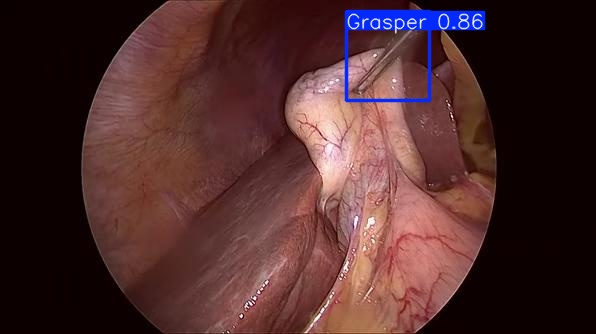

In [12]:
import os
from IPython.display import Image, display

pred_dir = "/kaggle/working/runs/detect/predict/m2cai_yolo14"
display(Image(filename="/kaggle/working/runs/detect/m2cai_yolo3/v01_004225.jpg"))

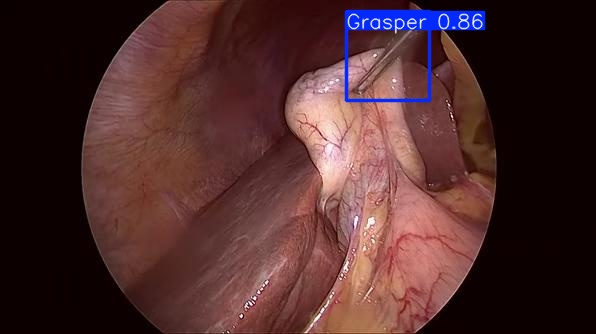

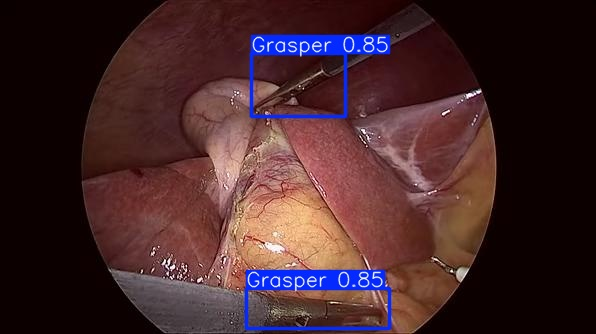

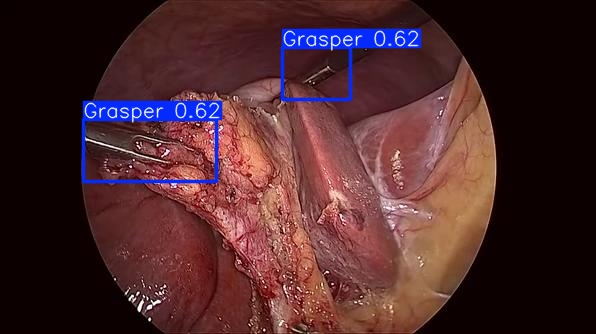

In [ ]:
import os
from IPython.display import Image, display

pred_dir = "/kaggle/working/runs/detect/m2cai_yolo3"

# Loop through and display all images in the predictions folder
for img_file in sorted(os.listdir(pred_dir)):
    if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(pred_dir, img_file)
        display(Image(filename=img_path))


In [ ]:
from ultralytics import YOLO

# Load your trained model - saved after previous step to prevent any loss of model (or redo the entire process, with this cell too)
model = YOLO("/kaggle/input/trained-yolov8/best.pt")  # Update if path is different

# Run inference on your test video
results = model.predict(source="/kaggle/input/test-vid/shortened3min_vid.mp4", save=True, conf=0.25)

print("✅ Inference done! Output saved in:", results[0].save_dir)

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from ultralytics import YOLO
import torch
# Load your segmentation model - https://www.kaggle.com/code/anmolys/cholecseg8k-yolov8/output
model = YOLO("/kaggle/input/best-seg/best _seg.pt")  # Update if path is different

# Run inference on your test video
results = model.predict(
    source="/kaggle/input/test-vid/shortened3min_vid.mp4",
    save=True,
    conf=0.25,
    device="cpu"
)

print("✅ Inference done! Output saved in:", results[0].save_dir)
torch.cuda.empty_cache()


In [ ]:
from moviepy.editor import VideoFileClip

# Load .avi and convert to .mp4
input_path = "/kaggle/working/runs/detect/predict/shortened3min_vid.avi"
output_path = "/kaggle/working/predicted_output.mp4"

clip = VideoFileClip(input_path)
clip.write_videofile(output_path, codec='libx264')

print("✅ Video converted to MP4:", output_path)


In [17]:
# Install Ultralytics if not already
!pip install ultralytics

# Import YOLO
from ultralytics import YOLO

# Load your model
model = YOLO('/kaggle/input/trained-yolov8/best.pt')  # e.g., 'runs/segment/train/weights/best.pt' after training

# Run validation
# This will calculate precision, recall, F1 score, IoU for each class
metrics = model.val(
    data='/kaggle/input/saved-yaml/data.yaml',    # Your dataset config
    split='val',                 # Use validation set
    save_json=True,              # Save COCO-style metrics
    iou=0.5                      # IoU threshold
)

# Now you can access detailed metrics
print("Overall Metrics:")
print(f"Precision: {metrics.box.p.mean():.4f}")
print(f"Recall: {metrics.box.r.mean():.4f}")
print(f"mAP50: {metrics.box.map50.mean():.4f}")
print(f"mAP50-95: {metrics.box.map.mean():.4f}")

Ultralytics 8.3.117 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1110.2±389.0 MB/s, size: 30.5 KB)


val: Scanning /kaggle/working/m2cai-yolo/labels/val.cache... 422 images, 0 backgrounds, 0 corrupt: 100%|██████████| 422/422 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


                   all        422        581      0.967      0.934       0.97      0.637
               Grasper        164        204      0.911      0.852      0.937      0.571
               Bipolar         65         65      0.968      0.933      0.954      0.592
                  Hook         44         44      0.999          1      0.995      0.792
              Scissors         60         60       0.98          1      0.995      0.636
               Clipper         66         66      0.979      0.924      0.979      0.668
             Irrigator         64         64      0.951      0.905      0.965      0.505
           SpecimenBag         78         78      0.982      0.923      0.964      0.694


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Saving runs/detect/val4/predictions.json...
Results saved to runs/detect/val4
Overall Metrics:
Precision: 0.9670
Recall: 0.9339
mAP50: 0.9701
mAP50-95: 0.6369


AttributeError: 'Metric' object has no attribute 'p_class'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    